## Access HERE API traffic data and saving to shapefile

#### Install herepy package

In [1]:
!pip install herepy #contextily rioxarray geocube

     |████████████████████████████████| 51 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 22.8 MB/s eta 0:00:01
  Attempting uninstall: requests
    Found existing installation: requests 2.24.0
    Uninstalling requests-2.24.0:
      Successfully uninstalled requests-2.24.0


In [2]:
import herepy
import requests
import json
import os
import urllib 

import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import shapely as shp
import geopandas as gpd
import shutil

#### HERE Traffic API request

In [3]:
area = [8.5,44.5,10,46.0]

In [4]:
key = open('here_api_key.txt')
key = key.read()

In [5]:
traffic_url = 'https://traffic.ls.hereapi.com/traffic/6.2/flow.json?\
apiKey=%s\
&bbox=%s,%s;%s,%s\
&responseattributes=sh,fc'%(key, area[3], area[0], area[1], area[2])

In [6]:
now = dt.now()
now = now.strftime('%Y%m%d_%H%M')

In [7]:
%%time
api_out = requests.get(traffic_url)
traffic = json.loads(api_out.content)

CPU times: user 1.17 s, sys: 188 ms, total: 1.36 s
Wall time: 5.28 s


In [8]:
%%time 

out = []

for it in traffic.get('RWS'):
    for rw in (it.get('RW')):
        for fis in (rw.get('FIS')):
            for fi in fis.get('FI'):
                DE = (fi.get('TMC').get('DE'))
                shape = fi.get('SHP')
                PC = fi.get('TMC').get('PC')
                QD = fi.get('TMC').get('QD')
                LE = fi.get('TMC').get('LE')
                
                zs = []

                for z in shape:
                    zs.append([[*map(float, x.split(','))][::-1] for x in z.get('value')[0].split(' ')[:-1]])

                line = shp.geometry.MultiLineString(zs)
                if len(fi.get('CF')) == 1:
                    SU = fi.get('CF')[0].get('SU')
                    SP = fi.get('CF')[0].get('SP')
                    JF = fi.get('CF')[0].get('JF')
                    FF = fi.get('CF')[0].get('FF')
                    CN = fi.get('CF')[0].get('CN')
                    
                else:
                    print('ERROR.')
                    
                out.append((DE, PC, QD, LE, SU, SP, JF, FF, CN, line))

CPU times: user 2.98 s, sys: 29.7 ms, total: 3.01 s
Wall time: 3.01 s


In [9]:
DE, PC, QD, LE, SU, SP, JF, FF, CN, geom = zip(*out)

In [10]:
gdf = gpd.GeoDataFrame(data=zip(DE, PC, QD, LE, SU, SP, JF, FF, CN), 
                       geometry=list(geom), 
                       columns=('DE', 'PC', 'QD', 'LE', 'SU', 'SP', 'JF', 'FF', 'CN'))
gdf.head()

,DE,PC,QD,LE,SU,SP,JF,FF,CN,geometry
0,Verzweigung Lugano-Nord,10153,+,1.33538,88.83,88.60,0.00000,75.3,0.98,"MULTILINESTRING ((8.92864 46.04003, 8.92870 46..."
1,Lugano-Nord,10819,+,0.18747,25.87,25.87,3.42907,47.0,0.99,"MULTILINESTRING ((8.93057 46.02776, 8.93052 46..."
2,Massagno,10820,+,1.71292,70.99,70.99,0.61865,76.3,0.98,"MULTILINESTRING ((8.93086 46.02729, 8.93101 46..."
3,Massagno,10820,-,0.05107,48.09,48.09,0.00000,39.0,0.82,"MULTILINESTRING ((8.93589 46.01725, 8.93617 46..."
4,Lugano-Nord,10819,-,1.67036,60.99,60.99,0.91607,68.0,0.94,"MULTILINESTRING ((8.93548 46.01695, 8.93528 46..."


In [11]:
gdf.shape

(9667, 10)

CPU times: user 11.1 s, sys: 183 ms, total: 11.2 s
Wall time: 11.2 s


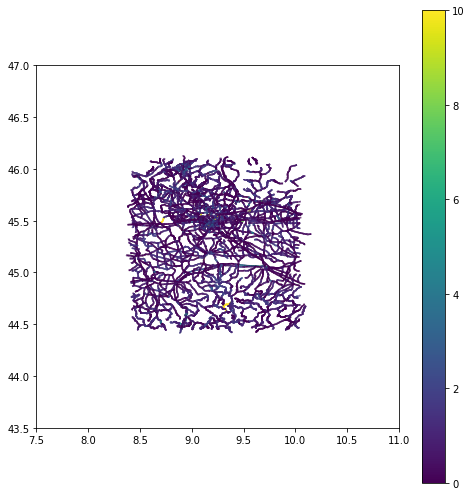

In [12]:
%%time 

fig, ax = plt.subplots(1,1, figsize=(7,7))
gdf.plot(ax=ax, column='JF', legend=True)
# countries.plot(ax=ax, fc='#bebebe', ec='black', zorder=-10)
ax.set_xlim(area[0]-1, area[2]+1)
ax.set_ylim(area[1]-1, area[3]+1)
plt.tight_layout()

In [13]:
gdf.to_file('here_traffic_', driver='ESRI Shapefile')
shutil.make_archive('data/traffic/%s'%now, 'zip', './here_traffic_/')
!rm -rf 'here_traffic_'

#### Run HERE traffic API request periodically to store temporal data

In [14]:
import time

In [15]:
gap = 15 # in minutes

In [16]:
for i in range(4):
    
    now = dt.now()
    now = now.strftime('%Y%m%d_%H%M')
    print(dt.now().strftime('%H:%M:%S'))
    
    api_out = requests.get(traffic_url)
    traffic = json.loads(api_out.content)
    
    out = []

    for it in traffic.get('RWS'):
        for rw in (it.get('RW')):
            for fis in (rw.get('FIS')):
                for fi in fis.get('FI'):
                    DE = (fi.get('TMC').get('DE'))
                    shape = fi.get('SHP')
                    PC = fi.get('TMC').get('PC')
                    QD = fi.get('TMC').get('QD')
                    LE = fi.get('TMC').get('LE')

                    zs = []

                    for z in shape:
                        zs.append([[*map(float, x.split(','))][::-1] for x in z.get('value')[0].split(' ')[:-1]])

                    line = shp.geometry.MultiLineString(zs)

                    speed = fi.get('CF')[0].get('SP')
                    jam = fi.get('CF')[0].get('FF')

                    out.append((DE, PC, QD, LE, speed, jam, line))
    
    DE, PC, QD, LE, speed, JF, geom = zip(*out)
    
    gdf = gpd.GeoDataFrame(data=zip(DE, PC, QD, LE, speed, JF), geometry=list(geom), columns=('DE', 'PC', 'QD', 'LE', 'speed', 'JF'))

    gdf.to_file('here_traffic_', driver='ESRI Shapefile')
    shutil.make_archive('data/traffic/%s'%now, 'zip', './here_traffic_/')
    !rm -rf 'here_traffic_'
    
    print('Iteration: %s \n'%i)
    time.sleep(60*gap)

11:33:57
Iteration: 0 

11:49:24
Iteration: 1 

12:04:51
Iteration: 2 

12:20:21
Iteration: 3 



___

#### Test

In [27]:
df1 = gpd.read_file('zip://data/traffic/20210703_2038.zip')
df2 = gpd.read_file('zip://data/traffic/20210704_0005.zip')

In [31]:
df2.head()

,DE,PC,QD,LE,speed,JF,geometry
0,Verzweigung Lugano-Nord,10153,+,1.33538,86.39,75.3,"MULTILINESTRING ((8.92864 46.04003, 8.92870 46..."
1,Lugano-Nord,10819,+,0.18747,53.15,47.0,"MULTILINESTRING ((8.93057 46.02776, 8.93052 46..."
2,Massagno,10820,+,1.71292,70.53,76.3,"MULTILINESTRING ((8.93086 46.02729, 8.93101 46..."
3,Massagno,10820,-,0.05107,40.00,39.0,"LINESTRING (8.93589 46.01725, 8.93617 46.01735..."
4,Lugano-Nord,10819,-,1.67036,67.49,68.0,"MULTILINESTRING ((8.93548 46.01695, 8.93528 46..."
